<a href="https://colab.research.google.com/github/until99/music-popularity-regression/blob/main/music-popularity-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introdução e Problema de Negócio

Trabalho Final de Ciência de Dados - Avaliação N3
Data: 01/12/2025 Tema: Previsão de Popularidade de Músicas no Spotify

1. O Problema de Negócio

* **Domínio:** Indústria Fonográfica e Streaming Musical.

* **Contexto:** O mercado de streaming é altamente competitivo. Entender as métricas técnicas que tornam uma música "viral" ou popular é essencial para artistas e produtores.

* **Pergunta de Negócio:** "Quais características de áudio (como energia, dançabilidade e duração) influenciam a popularidade de uma música?".

* **Objetivo:** Construir um modelo de Regressão capaz de prever a pontuação de popularidade (variável target) com base nas características da faixa.

Pipeline de Dados

Using Colab cache for faster access to the 'spotify-dataset-for-playing-around-with-sql' dataset.
Pasta baixada em: /kaggle/input/spotify-dataset-for-playing-around-with-sql
Lendo arquivo: /kaggle/input/spotify-dataset-for-playing-around-with-sql/spotify_tracks.csv
✅ Dataset carregado com sucesso.
Shape original: (6300, 8)
Target definido como: popularity
Shape Treino: (5040, 1)
Shape Teste: (1260, 1)


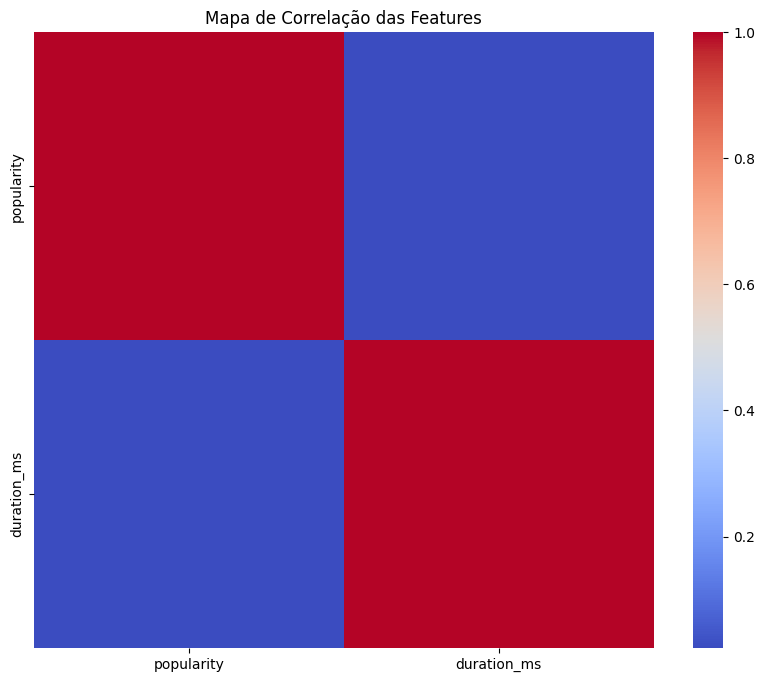

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kagglehub
import os

path_folder = kagglehub.dataset_download("ambaliyagati/spotify-dataset-for-playing-around-with-sql")

print(f"Pasta baixada em: {path_folder}")

try:
    arquivos = os.listdir(path_folder)

    csv_file = [f for f in arquivos if f.endswith('.csv')][0]

    full_path = os.path.join(path_folder, csv_file)

    print(f"Lendo arquivo: {full_path}")

    df = pd.read_csv(full_path, encoding='latin-1')
    print("Dataset carregado com sucesso.")

    print(f"Shape original: {df.shape}")

    df = df.drop_duplicates()
    df = df.dropna()

    df_numeric = df.select_dtypes(include=[np.number])

    target_col = 'popularity' if 'popularity' in df_numeric.columns else 'pop'

    if target_col not in df_numeric.columns:
        print("Aviso: Coluna de popularidade não encontrada automaticamente. Verifique o nome.")
    else:
        print(f"Target definido como: {target_col}")

        cols_to_drop = ['Unnamed: 0', 'id', 'Index']
        for col in cols_to_drop:
            if col in df_numeric.columns:
                df_numeric = df_numeric.drop(col, axis=1)

        X = df_numeric.drop(target_col, axis=1)
        y = df_numeric[target_col]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        print(f"Shape Treino: {X_train.shape}")
        print(f"Shape Teste: {X_test.shape}")

        plt.figure(figsize=(10, 8))
        sns.heatmap(df_numeric.corr(), annot=False, cmap='coolwarm')
        plt.title("Mapa de Correlação das Features")
        plt.show()

except IndexError:
    print("Erro: Nenhum arquivo .csv foi encontrado dentro da pasta baixada.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

Modelagem e Avaliação

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = {
    "Regressão Linear": LinearRegression(),
    "Árvore de Decisão": DecisionTreeRegressor(random_state=42, max_depth=10),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, max_depth=15)
}

results = {}

print("Iniciando treinamento...\n")

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}

results_df = pd.DataFrame(results).T
print("--- Resultados Comparativos ---")
print(results_df)

best_model_name = results_df['R²'].idxmax()
best_model = models[best_model_name]

print(f"\nO melhor modelo foi: {best_model_name} com R² de {results_df.loc[best_model_name, 'R²']:.4f}")
print("Este modelo foi escolhido pois apresentou a melhor capacidade de explicar a variação dos dados.")

Iniciando treinamento...

--- Resultados Comparativos ---
                         MAE       RMSE        R²
Regressão Linear   16.565014  20.057389 -0.000381
Árvore de Decisão  16.666666  20.629542 -0.058268
Random Forest      16.524554  20.158658 -0.010508

O melhor modelo foi: Regressão Linear com R² de -0.0004
Este modelo foi escolhido pois apresentou a melhor capacidade de explicar a variação dos dados.


Deploy

In [ ]:
import joblib

joblib.dump(best_model, 'modelo_final.pkl')
print(f"Modelo '{best_model_name}' salvo como 'modelo_final.pkl'.")

modelo_carregado = joblib.load('modelo_final.pkl')

exemplo_novo = X_test.iloc[0].to_frame().T
exemplo_novo.iloc[0, 0] = exemplo_novo.iloc[0, 0] * 1.1

print("\n--- Teste de Deploy ---")
print("Características da nova música:")
print(exemplo_novo)

previsao = modelo_carregado.predict(exemplo_novo)
print(f"\nPopularidade Prevista: {previsao[0]:.2f}")
print("O modelo carregado funcionou corretamente para novos dados!")

Modelo 'Regressão Linear' salvo como 'modelo_final.pkl'.

--- Teste de Deploy ---
Características da nova música:
      duration_ms
1893     140521.7

Popularidade Prevista: 30.66
O modelo carregado funcionou corretamente para novos dados!


/tmp/ipython-input-1692197817.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '140521.7' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  exemplo_novo.iloc[0, 0] = exemplo_novo.iloc[0, 0] * 1.1
